# source files
##### Copyright 2019 The TensorFlow Authors.
# 시계열 예측


In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## 날씨 데이터세트

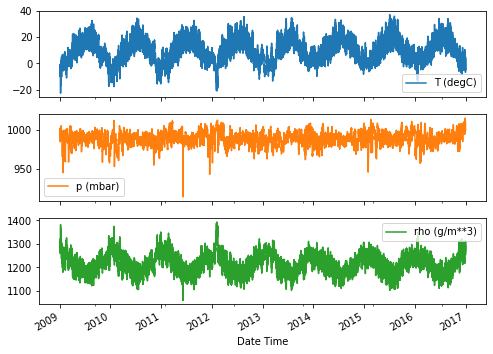

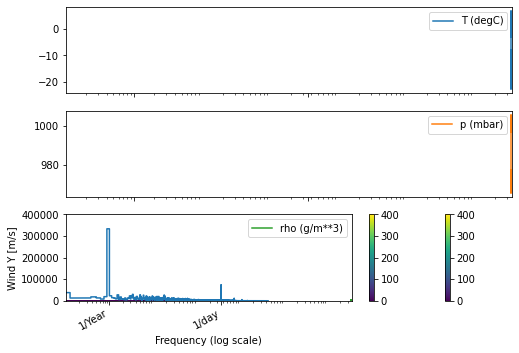

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)


df = pd.read_csv(csv_path)
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')


plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)


# 검사 및 정리하기


wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
df['wv (m/s)'].min()

plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

#그러나 풍향과 속도 열을 바람 **벡터**로 변환하면 모델이 해석하기가 더 쉽습니다.


wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)


plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')


# 시간

timestamp_s = date_time.map(datetime.datetime.timestamp)



day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))



# 모델이 가장 중요한 빈도 특성

fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

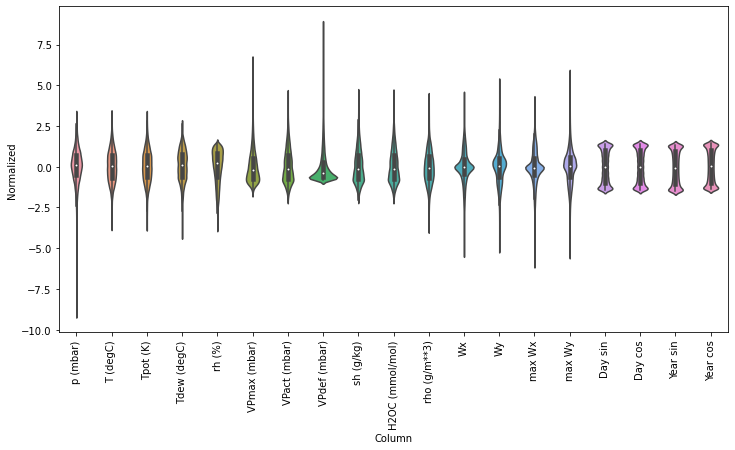

In [3]:
### 데이터 분할

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

# ## 데이터 정규화

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std



df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [4]:
# short data
train_df_s = train_df[:1000]
val_df_s = val_df[:1000]
test_df_s = test_df[:1000]

## 데이터 창 작업

In [8]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.train_df_s = train_df_s
    self.val_df = val_df
    self.val_df_s = val_df_s
    self.test_df = test_df
    self.test_df_s = test_df_s

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
#  print(f'in split_window : {inputs}')
  labels_t = tf.identity(labels)
  labels_t = tf.stack( [labels[:, :, 0:4]])
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)
  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])
#  print(f'in split_window : {inputs}')

#  return inputs, labels, labels_t
  return inputs, labels

WindowGenerator.split_window = split_window


def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
#      shuffle=True,
      batch_size=32,)
#  print(f'in make dataset before split : {ds}')

  ds = ds.map(self.split_window)
#  print(f'in make dataset after split : {ds}')
  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
#  return self.make_dataset(self.train_df)
  return self.make_dataset(self.train_df_s)

@property
def val(self):
#  return self.make_dataset(self.val_df)
  return self.make_dataset(self.val_df_s)

@property
def test(self):
#  return self.make_dataset(self.test_df)
  return self.make_dataset(self.test_df_s)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


#example_inputs, example_labels, lab = w2.split_window(example_window)
example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')
#print(lab)

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
labels shape: (3, 1, 1)


In [8]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window


def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
#  for n in range(3, 32):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot




# next(iter(wide_window.train))

In [9]:
dataset = wide_window.train
for batch in dataset :
  inputs, targets, lab = batch
print(batch[0])

ValueError: not enough values to unpack (expected 3, got 2)

In [10]:
a = next(iter(wide_window.train))

```

n=0
for example_inputs, example_labels in wide_window.train.take(2):
#for example_inputs, example_labels in wide_window.train:
  print(n)
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')
#  print(f'Inputs shape (batch, time, features): {example_inputs[31][23][18]}')
#  print(f'Inputs shape (batch, time, features): {example_inputs[0][0:2][:]}')
#  print(f'Inputs shape (batch, time, features): {example_inputs}')
  n+=1


wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

#wide_window

wide_window.plot(linear)
```

```

single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')
#  print(f'Inputs shape (batch, time, features): {example_inputs[0][0]}')
#  print(example_inputs)


#single_step_window.train(2)


wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window
```

In [11]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window
n=1
for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')
  print(n)
  n+=1
#wide_window

#e_in = wide_window.train.take(1)
#print(e_in)



Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 1)
1


```
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')


example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])


example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')



print(f'Labels shape (batch, time, features): {example_inputs[0][0][:]}')
```

```
data3 = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20, 21
         ,22,23,24,25,26,27,28,29,30,31,32]
input_data3 = data3[:-5]
targets3 = data3[5:]
dataset3 = tf.keras.preprocessing.timeseries_dataset_from_array(
#    input_data3, targets3, sequence_length=10)
    input_data3, targets3, sequence_length=10, batch_size=5)
num_batch = 0
for batch3 in dataset3:
  a, b = batch3
#  assert np.array_equal(inputs3[0], data3[:10])  # First sequence: steps [0-9]
#  assert np.array_equal(targets3[0], data3[10])  # Corresponding target: step 10
#  break
  print(num_batch)
  print(a)
  print(b)
  print(batch3)
  num_batch +=1

```

```
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
#  for n in range(3, 32):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

```

In [12]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])

# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

#print(example_inputs)



All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
labels shape: (3, 1, 1)


Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


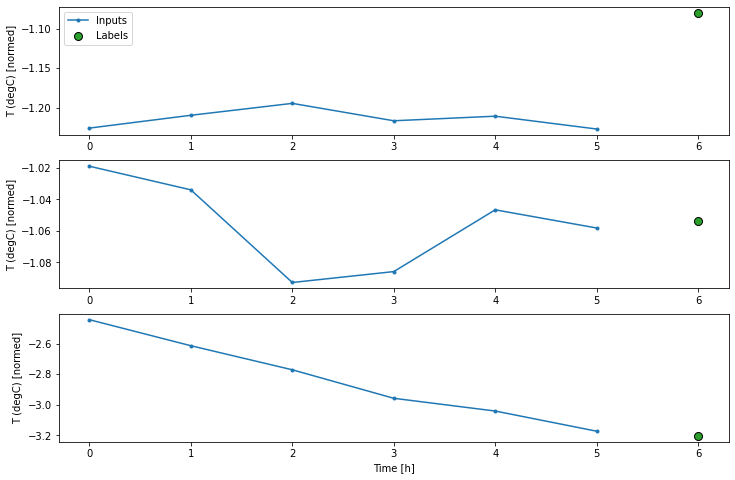

In [13]:
#w2.example = example_inputs, example_labels


w2.plot()


# ## 4. `tf.data.Dataset` 만들기

# Each element is an (inputs, label) pair
w2.train.element_spec

# `Dataset`를 반복하면 구체적인 배치가 생성됩니다.

for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')


## 단일 스텝 모델

In [22]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

In [23]:
n=1
for example_inputs, example_labels in single_step_window.train.take(2000): #1534, 6
#for example_inputs, example_labels in single_step_window.train.take(3):
#for example_inputs, example_labels in wide_window.train.take(2000): #1533 15
  print(n)
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')
  n += 1


1
Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)
2
Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)
3
Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)
4
Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)
5
Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)
6
Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)
7
Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)
8
Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)
9
Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)
10
Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): 

### 기준

In [24]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [28]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

32/32 [==============================] - 0s 980us/step - loss: 0.0142 - mean_absolute_error: 0.0819


In [35]:
val_performance = {}

for inputs, labels in single_step_window.val.take(50):
#    xin = tf.stack(inputs, axis=-1)
#    xin = tf.stack(inputs)
#    yin = tf.stack(labels, axis=-1)
 #   yin = tf.stack(labels)

#xin.set_shape([None, 1, None])
#yin.set_shape([None, 1, None])

#    val_performance['Baseline'] = baseline.evaluate(xin, yin)
    val_performance['Baseline']  = baseline.evaluate(inputs, labels)
   # val_performance['Baseline'] = val_performance['Baseline'] + val_p

1/1 [==============================] - 0s 0s/step - loss: 0.0097 - mean_absolute_error: 0.0827


In [82]:
# empty dictionary
val_performance = {}
val_performance['Baseline']  = baseline.evaluate(inputs, labels)
val_performance['Baseline']
#val_performance= {'Baseline': [12,3], 'temp': [4]}
#val_performance['temp']+val_performance['temp']
#values = val_performance.values()
val_performance.get("Baseline")
#val_performance["a"] = val_performance.get("Baseline", 0) + 1
#val_performance["a"]






1/1 [==============================] - 0s 1ms/step - loss: 0.0097 - mean_absolute_error: 0.0827


TypeError: can only concatenate list (not "int") to list

In [43]:
xin.shape

TensorShape([1, 19, 32])

in make dataset before split : <BatchDataset shapes: (None, None, 19), types: tf.float32>
in split_window : Tensor("strided_slice:0", shape=(None, None, 19), dtype=float32)
in split_window : Tensor("strided_slice:0", shape=(None, 24, 19), dtype=float32)
in make dataset after split : <MapDataset shapes: ((None, 24, 19), (None, 24, 1)), types: (tf.float32, tf.float32)>
in make dataset before split : <BatchDataset shapes: (None, None, 19), types: tf.float32>
in split_window : Tensor("strided_slice:0", shape=(None, None, 19), dtype=float32)
in split_window : Tensor("strided_slice:0", shape=(None, 24, 19), dtype=float32)
in make dataset after split : <MapDataset shapes: ((None, 24, 19), (None, 24, 1)), types: (tf.float32, tf.float32)>
31/31 [==============================] - 0s 934us/step - loss: 0.0143 - mean_absolute_error: 0.0822
in make dataset before split : <BatchDataset shapes: (None, None, 19), ty

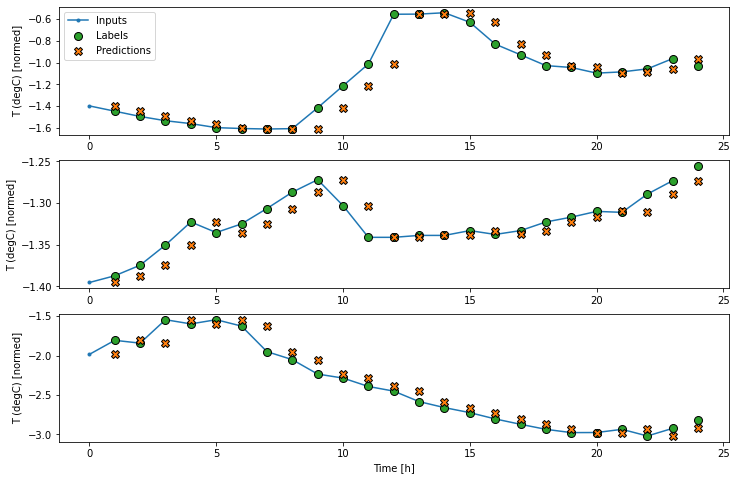

In [15]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window


wide_window.plot(baseline)

val_performance['Baseline_wide'] = baseline.evaluate(wide_window.val)
performance['Baseline_wide'] = baseline.evaluate(wide_window.test, verbose=0)

print(f'val_performance :{val_performance}')
print(f'test_performance :{performance}')

### 선형 모델

In [29]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [17]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

in make dataset before split : <BatchDataset shapes: (None, None, 19), types: tf.float32>
in split_window : Tensor("strided_slice:0", shape=(None, None, 19), dtype=float32)
in split_window : Tensor("strided_slice:0", shape=(None, 1, 19), dtype=float32)
in make dataset after split : <MapDataset shapes: ((None, 1, 19), (None, 1, 1)), types: (tf.float32, tf.float32)>
Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


In [18]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [19]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)


in make dataset before split : <BatchDataset shapes: (None, None, 19), types: tf.float32>
in split_window : Tensor("strided_slice:0", shape=(None, None, 19), dtype=float32)
in split_window : Tensor("strided_slice:0", shape=(None, 1, 19), dtype=float32)
in make dataset after split : <MapDataset shapes: ((None, 1, 19), (None, 1, 1)), types: (tf.float32, tf.float32)>
in make dataset before split : <BatchDataset shapes: (None, None, 19), types: tf.float32>
in split_window : Tensor("strided_slice:0", shape=(None, None, 19), dtype=float32)
in split_window : Tensor("strided_slice:0", shape=(None, 1, 19), dtype=float32)
in make dataset after split : <MapDataset shapes: ((None, 1, 19), (None, 1, 1)), types: (tf.float32, tf.float32)>
Epoch 1/20
32/32 [==============================] - 0s 4ms/step - loss: 4.6853 - mean_absolute_error: 1.6992 - val_loss: 1.0105 - val_mean_absolute_error: 0.8839
Epoch 2/20
32/32 [==============================] - 0s 2ms/step - lo

In [20]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


in make dataset before split : <BatchDataset shapes: (None, None, 19), types: tf.float32>
in split_window : Tensor("strided_slice:0", shape=(None, None, 19), dtype=float32)
in split_window : Tensor("strided_slice:0", shape=(None, 24, 19), dtype=float32)
in make dataset after split : <MapDataset shapes: ((None, 24, 19), (None, 24, 1)), types: (tf.float32, tf.float32)>
in make dataset before split : <BatchDataset shapes: (None, None, 19), types: tf.float32>
in split_window : Tensor("strided_slice:0", shape=(None, None, 19), dtype=float32)
in split_window : Tensor("strided_slice:0", shape=(None, 24, 19), dtype=float32)
in make dataset after split : <MapDataset shapes: ((None, 24, 19), (None, 24, 1)), types: (tf.float32, tf.float32)>
Epoch 1/20
31/31 [==============================] - 0s 5ms/step - loss: 0.0084 - mean_absolute_error: 0.0675 - val_loss: 0.0555 - val_mean_absolute_error: 0.1777
Epoch 2/20
31/31 [==============================] - 0s 2ms/step - loss: 0.0083 - mean_absolute_err

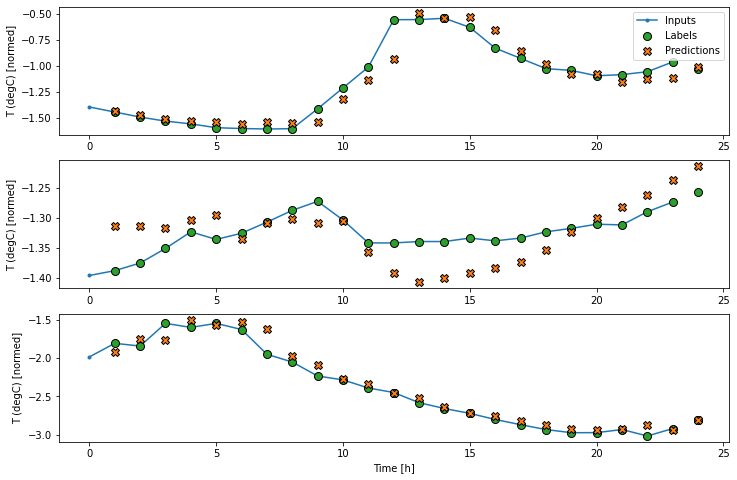

In [34]:
history = compile_and_fit(linear, wide_window)

wide_window.plot(linear)

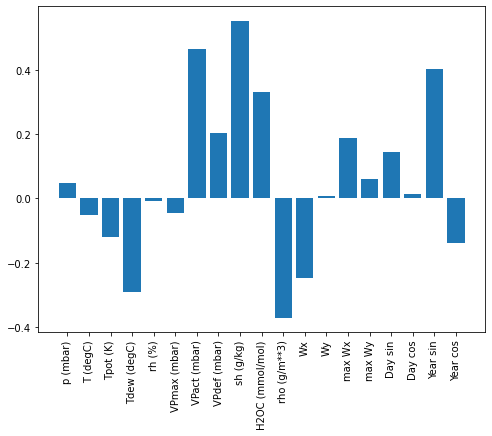

In [102]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

### 밀집

In [103]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
32/32 [==============================] - 0s 6ms/step - loss: 0.0923 - mean_absolute_error: 0.2185 - val_loss: 2.2153 - val_mean_absolute_error: 1.4050
Epoch 2/20
32/32 [==============================] - 0s 3ms/step - loss: 0.0152 - mean_absolute_error: 0.0917 - val_loss: 1.7332 - val_mean_absolute_error: 1.2331
Epoch 3/20
32/32 [==============================] - 0s 2ms/step - loss: 0.0096 - mean_absolute_error: 0.0729 - val_loss: 1.5165 - val_mean_absolute_error: 1.1444
Epoch 4/20
32/32 [==============================] - 0s 3ms/step - loss: 0.0080 - mean_absolute_error: 0.0672 - val_loss: 1.3858 - val_mean_absolute_error: 1.0888
Epoch 5/20
32/32 [==============================] - 0s 2ms/step - loss: 0.0070 - mean_absolute_error: 0.0631 - val_loss: 1.2946 - val_mean_absolute_error: 1.0467
Epoch 6/20

### 다중 스텝 밀집

In [104]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 1.0, 'Given 3h as input, predict 1h into the future.')

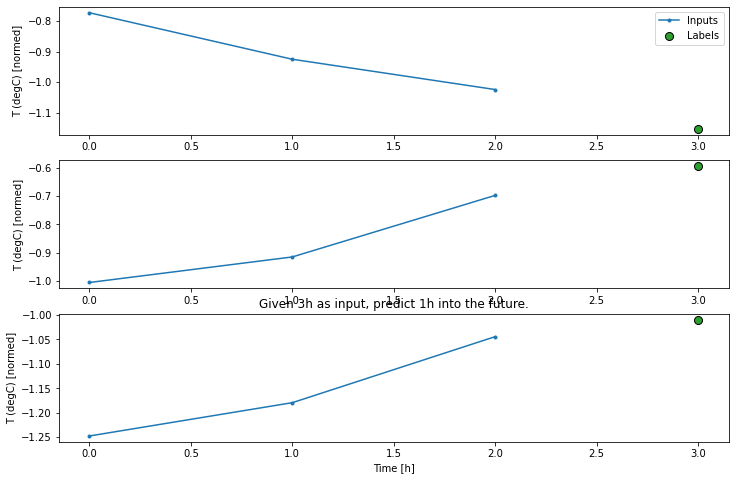

In [105]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

`layers.Flatten`을 모델의 첫 번째 레이어로 추가하여 다중 입력 스텝 창에서 `dense` 모델을 훈련할 수 있습니다.

In [106]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [107]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [108]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

32/32 [==============================] - 0s 717us/step - loss: 3.7788 - mean_absolute_error: 1.8158


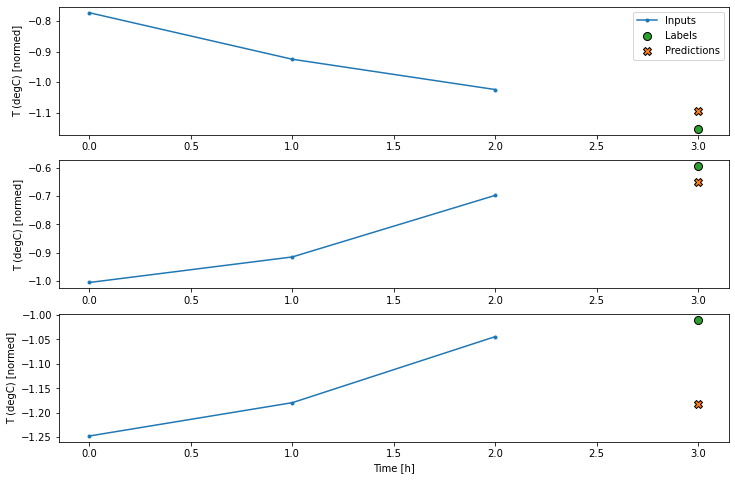

In [109]:
conv_window.plot(multi_step_dense)


이 접근법의 주된 단점은 결과적인 모델이 정확히 이 형상의 입력 창에서만 실행될 수 있다는 것입니다. 

In [110]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 19)

InvalidArgumentError:Matrix size-incompatible: In[0]: [32,456], In[1]: [57,32] [Op:MatMul]


다음 섹션의 컨볼루셔널 모델은 이 문제를 해결합니다.

### 컨볼루션 신경망

컨볼루션 레이어(`layers.Conv1D`)도 각 예측에 대한 입력으로 여러 타임스텝을 사용합니다.

다음은 컨볼루션으로 다시 작성한 `multi_step_dense`와 **동일한** 모델입니다.

다음 변경 사항에 주목하세요.

- `layers.Flatten`과 첫 번째 `layers.Dense`는 `layers.Conv1D`로 대체됩니다.
- 컨볼루션이 출력에서 시간 축을 유지하므로 `layers.Reshape`는 이 더 이상 필요하지 않습니다.

In [111]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

예제 배치에서 실행하여 모델이 예상된 형상으로 출력을 생성하는지 확인합니다.

In [112]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [113]:
n=1
for example_inputs, example_labels in conv_window.train.take(2000): #1534, 6
#for example_inputs, example_labels in single_step_window.train.take(3):
#for example_inputs, example_labels in wide_window.train.take(2000): #1533 15
  print(n)
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')
  n += 1


1
Inputs shape (batch, time, features): (32, 3, 19)
Labels shape (batch, time, features): (32, 1, 1)
2
Inputs shape (batch, time, features): (32, 3, 19)
Labels shape (batch, time, features): (32, 1, 1)
3
Inputs shape (batch, time, features): (32, 3, 19)
Labels shape (batch, time, features): (32, 1, 1)
4
Inputs shape (batch, time, features): (32, 3, 19)
Labels shape (batch, time, features): (32, 1, 1)
5
Inputs shape (batch, time, features): (32, 3, 19)
Labels shape (batch, time, features): (32, 1, 1)
6
Inputs shape (batch, time, features): (32, 3, 19)
Labels shape (batch, time, features): (32, 1, 1)
7
Inputs shape (batch, time, features): (32, 3, 19)
Labels shape (batch, time, features): (32, 1, 1)
8
Inputs shape (batch, time, features): (32, 3, 19)
Labels shape (batch, time, features): (32, 1, 1)
9
Inputs shape (batch, time, features): (32, 3, 19)
Labels shape (batch, time, features): (32, 1, 1)
10
Inputs shape (batch, time, features): (32, 3, 19)
Labels shape (batch, time, features): 

`conv_window`에서 훈련하고 평가하면 `multi_step_dense` 모델과 유사한 성능을 제공해야 합니다.

In [114]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

32/32 [==============================] - 0s 749us/step - loss: 0.2505 - mean_absolute_error: 0.4314


이 `conv_model`과 `multi_step_dense` 모델의 차이점은 `conv_model`은 모든 길이의 입력에서 실행될 수 있다는 것입니다. 컨볼루셔널 레이어는 입력의 슬라이딩 윈도우에 적용됩니다.

![Executing a convolutional model on a sequence](https://www.tensorflow.org/tutorials/structured_data/images/wide_conv_window.png)

더 넓은 입력에서 실행하면 더 넓은 출력이 생성됩니다.

In [115]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


출력은 입력보다 짧습니다. 훈련 또는 플롯 작업을 수행하려면 레이블과 예상의 길이가 동일해야 합니다. 따라서 레이블과 예측 길이가 일치하도록 몇 개의 추가 입력 타임스텝으로 넓은 창을 생성하는 `WindowGenerator`를 빌드합니다. 

In [116]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [117]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


In [118]:
n=1
for example_inputs, example_labels in wide_conv_window.train.take(2000): #1534, 6
#for example_inputs, example_labels in single_step_window.train.take(3):
#for example_inputs, example_labels in wide_window.train.take(2000): #1533 15
  print(n)
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')
  n += 1

1
Inputs shape (batch, time, features): (32, 26, 19)
Labels shape (batch, time, features): (32, 24, 1)
2
Inputs shape (batch, time, features): (32, 26, 19)
Labels shape (batch, time, features): (32, 24, 1)
3
Inputs shape (batch, time, features): (32, 26, 19)
Labels shape (batch, time, features): (32, 24, 1)
4
Inputs shape (batch, time, features): (32, 26, 19)
Labels shape (batch, time, features): (32, 24, 1)
5
Inputs shape (batch, time, features): (32, 26, 19)
Labels shape (batch, time, features): (32, 24, 1)
6
Inputs shape (batch, time, features): (32, 26, 19)
Labels shape (batch, time, features): (32, 24, 1)
7
Inputs shape (batch, time, features): (32, 26, 19)
Labels shape (batch, time, features): (32, 24, 1)
8
Inputs shape (batch, time, features): (32, 26, 19)
Labels shape (batch, time, features): (32, 24, 1)
9
Inputs shape (batch, time, features): (32, 26, 19)
Labels shape (batch, time, features): (32, 24, 1)
10
Inputs shape (batch, time, features): (32, 26, 19)
Labels shape (batch

이제 더 넓은 창에 모델의 예측값을 플롯할 수 있습니다. 첫 번째 예측 전 3개의 입력 타임스텝에 주목하세요. 여기서 모든 예측은 이전 3개의 타임스텝에 기초합니다.

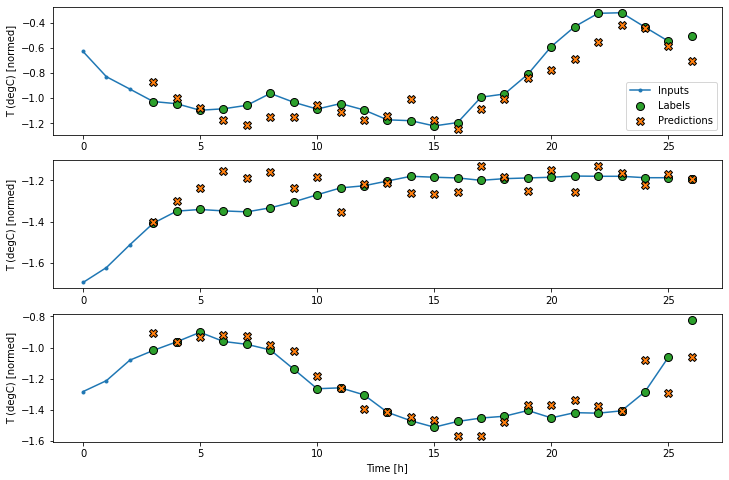

In [119]:
wide_conv_window.plot(conv_model)

### 순환 신경망

Recurrent Neural Network(RNN)는 시계열 데이터에 적합한 신경망 유형입니다. RNN은 시계열을 단계별로 처리하여 타임스텝 사이에서 내부 상태를 유지합니다.

자세한 내용은 [텍스트 생성 튜토리얼](https://www.tensorflow.org/tutorials/text/text_generation) 또는 [RNN 가이드](https://www.tensorflow.org/guide/keras/rnn)를 읽어보세요.

이 튜토리얼에서는 [Long Short Term Memory](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM)(LSTM)이라는 RNN 레이어를 사용합니다.

모든 keras RNN 레이어에 대한 중요한 생성자 인수는 `return_sequences` 인수입니다. 이 설정은 다음 두 가지 방법 중 하나로 레이어를 구성할 수 있습니다.

1. 기본값인 `False`인 경우 레이어는 최종 타임스텝의 출력만 반환하여 단일 예측을 수행하기 전에 모델이 내부 상태를 준비할 시간을 줍니다.

![An lstm warming up and making a single prediction](https://www.tensorflow.org/tutorials/structured_data/images/lstm_1_window.png)

1. `True`이면 레이어가 각 입력에 대한 출력을 반환합니다. 다음과 같은 경우에 유용합니다.

- RNN 레이어 쌓기
- 여러 타임스텝에서 동시에 모델 훈련

![An lstm making a prediction after every timestep](https://www.tensorflow.org/tutorials/structured_data/images/lstm_many_window.png)

In [120]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

`return_sequences=True`이면 모델을 한 번에 24시간 분량 데이터에 대해 훈련할 수 있습니다.

참고: 이 경우에는 모델 성능의 관점에서 기대할 것이 없습니다. 첫 번째 타임스텝에서 모델이 이전 스텝에 액세스할 수 없으므로 이전에 표시한 단순한 `linear` 및 `dense` 모델보다 더 나을 것이 없기 때문입니다.

In [121]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


In [122]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

31/31 [==============================] - 0s 1ms/step - loss: 0.4272 - mean_absolute_error: 0.4954


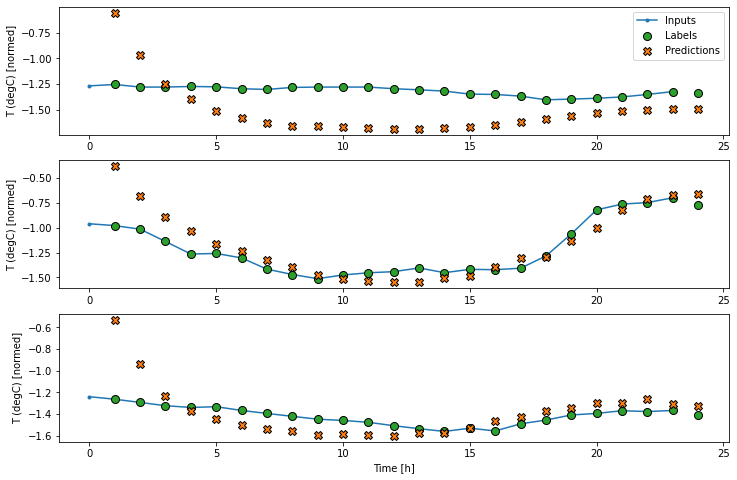

In [123]:
wide_window.plot(lstm_model)

### 성능

이 데이터세트를 사용하면 일반적으로 각 모델의 성능이 이전 모델보다 약간 더 좋습니다.

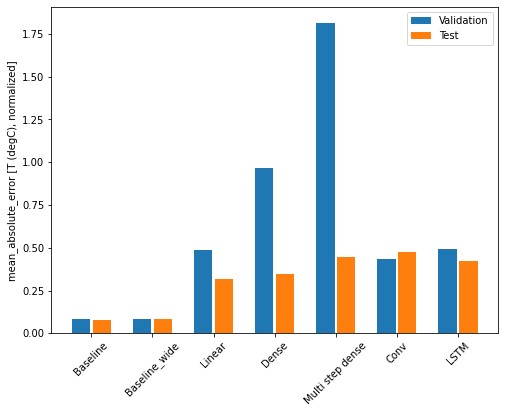

In [124]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [125]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0806
Baseline_wide: 0.0808
Linear      : 0.3190
Dense       : 0.3458
Multi step dense: 0.4453
Conv        : 0.4745
LSTM        : 0.4205


### 다중 출력 모델

지금까지 모델은 모두 단일 타임스텝에 대해 단일 출력 특성 `T (degC)`를 예측했습니다.

이러한 모든 모델은 간단히 출력 레이어의 단위 수를 변경하고 `labels`에 모든 특성을 포함하도록 훈련 창을 조정하여 여러 특성을 예측하도록 변환할 수 있습니다.


In [126]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


레이블의 `features` 축은 이제 1이 아닌 입력과 동일한 깊이를 갖습니다.

#### 기준

여기서는 동일한 기준 모델을 사용할 수 있지만 이번에는 특정 `label_index`를 선택하는 대신 모든 특성을 반복합니다.

In [127]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [128]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

31/31 [==============================] - 0s 709us/step - loss: 0.0908 - mean_absolute_error: 0.1666


#### 밀집

In [129]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [130]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

32/32 [==============================] - 0s 748us/step - loss: 1.2501 - mean_absolute_error: 0.9485


#### RNN


In [131]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

31/31 [==============================] - 0s 2ms/step - loss: 0.7596 - mean_absolute_error: 0.7141

Wall time: 4.08 s


<a id="residual"></a>

#### 고급: 잔여 연결

이전의 `Baseline` 모델은 시퀀스가 타임스텝 사이에서 크게 변하지 않는다는 사실을 이용했습니다. 지금까지 이 튜토리얼에서 훈련한 모든 모델은 무작위로 초기화된 다음, 출력이 이전 타임스텝에서 약간 변경된다는 사실을 학습해야 했습니다.

신중한 초기화로 이 문제를 해결할 수 있지만 모델 구조로 빌드하는 것이 더 간단합니다.

시계열 분석에서는 다음 값을 예측하는 대신 다음 타임스텝에서 값이 어떻게 달라지는 지를 예측하는 모델을 빌드하는 것이 일반적입니다. 마찬가지로 딥러닝에서 "잔여 네트워크(Residual networks)" 또는 "ResNets"는 각 레이어가 모델의 누적 결과에 추가되는 아키텍처를 나타냅니다.

이것은 변화가 작아야 한다는 사실을 이용하는 방법입니다.

![A model with a residual connection](https://www.tensorflow.org/tutorials/structured_data/images/residual.png)

기본적으로, `Baseline`과 일치하도록 모델을 초기화합니다. 그러면 이 작업에서 약간 더 나은 성능으로 모델이 더 빨리 수렴하는 데 도움이 됩니다.

이 접근 방식은 이 튜토리얼에서 설명하는 모든 모델과 연계하여 사용할 수 있습니다.

여기서는 LSTM 모델에 적용합니다. `tf.initializers.zeros`를 사용하여 초기 예측하는 변경이 작고 잔류 연결을 억제하지 않도록 한다는 점에 주목하세요. `zeros`가 마지막 레이어에서만 사용되기 때문에 여기에서 그래디언트에 대한 대칭성이 깨질 우려는 없습니다.

In [132]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [133]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

31/31 [==============================] - 0s 2ms/step - loss: 0.0869 - mean_absolute_error: 0.1613

Wall time: 3.23 s


#### 성능

다음은 이러한 다중 출력 모델의 전반적인 성능입니다.

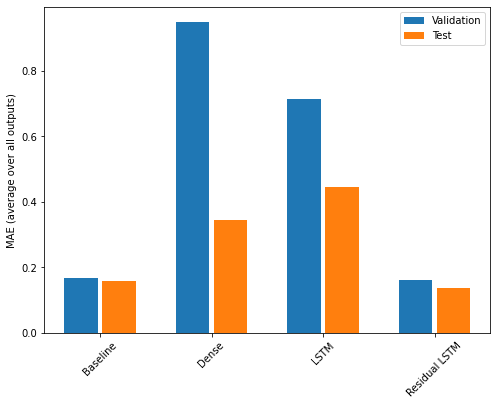

In [134]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [135]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1599
Dense          : 0.3461
LSTM           : 0.4461
Residual LSTM  : 0.1384


위의 성능은 모든 모델 출력에 대한 평균입니다.

## 다중 스텝 모델

이전 섹션의 단일 출력 및 다중 출력 모델은 모두 미래 1시간의 **단일 타임스텝 예측**을 수행했습니다.

이 섹션에서는 이러한 모델을 확장하여 **다중 타임스텝 예측**을 수행하는 방법을 살펴봅니다.

다중 스텝 예측에서 모델은 일정 범위의 미래 값을 예측하는 방법을 학습해야 합니다. 따라서 한 미래 시점만 예측하는 단일 스텝 모델과 달리 다중 스텝 모델은 미래 값의 시퀀스를 예측합니다.

대략적으로 두 가지 접근 방식이 있습니다.

1. 전체 시계열이 한 번에 예측되는 싱글샷 예측
2. 모델이 단일 스텝 예측만 수행하고 출력이 입력으로 피드백되는 자기 회귀적 예측

이 섹션에서는 모든 모델이 **모든 출력 타임스텝에 걸쳐 모든 특성**을 예측합니다.


다중 스텝 모델의 경우, 훈련 데이터는 다시 시간별 샘플로 구성됩니다. 그러나 여기에서 모델은 과거의 24시간을 고려하여 미래 24시간을 예측하는 방법을 학습합니다.

다음은 데이터세트로부터 이러한 조각을 생성하는 `Window` 객체입니다.

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

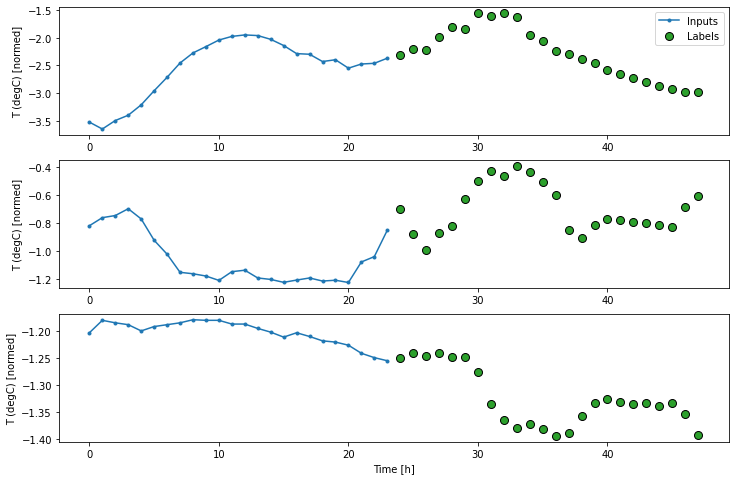

In [136]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### 기준

이 작업의 간단한 기준은 필요한 출력 타임스텝 수에 대해 마지막 입력 타임스텝을 반복하는 것입니다.

![Repeat the last input, for each output step](https://www.tensorflow.org/tutorials/structured_data/images/multistep_last.png)

30/30 [==============================] - 0s 732us/step - loss: 0.6294 - mean_absolute_error: 0.5160


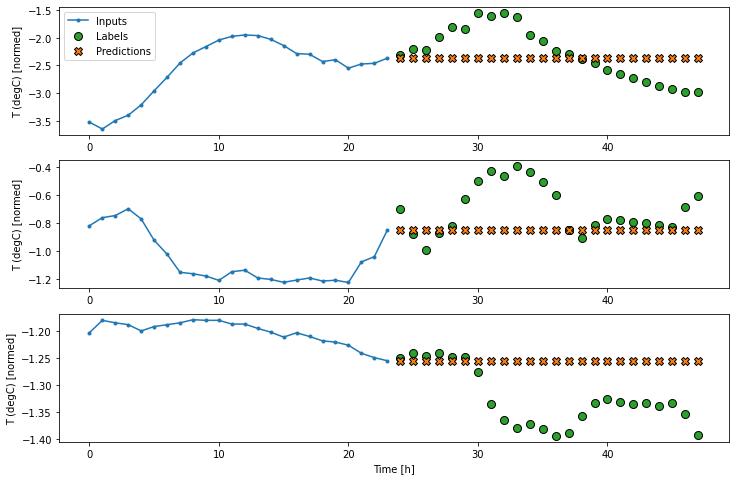

In [137]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.val, verbose=0)
multi_window.plot(last_baseline)

이 작업은 24시간이 주어졌을 때 24시간을 예측하는 것이므로 또 다른 간단한 접근 방법은 내일도 비슷하다는 가정 하에 전날을 반복하는 것입니다.

![Repeat the previous day](https://www.tensorflow.org/tutorials/structured_data/images/multistep_repeat.png)

30/30 [==============================] - 0s 665us/step - loss: 0.3626 - mean_absolute_error: 0.3701


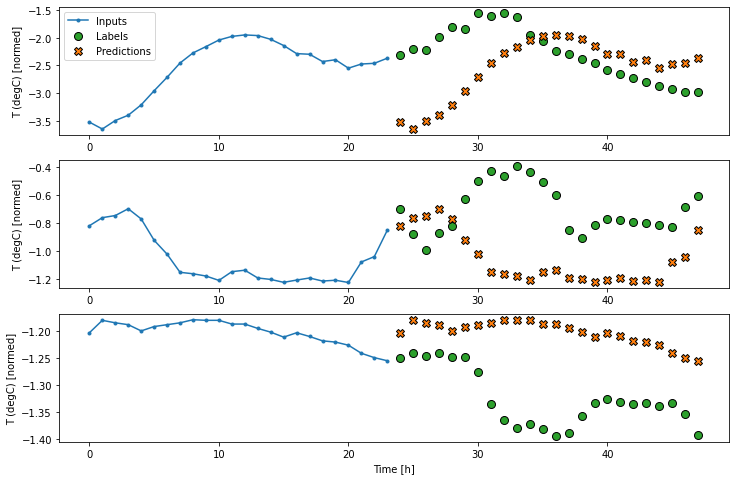

In [138]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### 싱글샷 모델

이 문제에 대한 한 가지 높은 수준의 접근 방법은 모델이 한 번에 전체 시퀀스 예측을 수행하는 "싱글샷" 모델을 사용하는 것입니다.

이 모델은 `OUT_STEPS*features` 출력 단위를 이용해 `layers.Dense`로 효율적으로 구현할 수 있습니다. 이 모델은 이 출력의 형상을 필요한 `(OUTPUT_STEPS, features)`로 바꾸기만 하면 됩니다.

#### 선형

마지막 입력 타임스텝을 기반으로 하는 단순한 선형 모델은 기준 모델보다 성능이 더 좋지만 강력하지 못합니다. 이 모델은 선형 프로젝션을 이용해 단일 입력 타임스텝으로부터 `OUTPUT_STEPS` 타임스텝을 예측해야 합니다. 주로 하루 중 시간과 연중 시간을 기반으로 하는 행동의 저차원 조각만 캡처할 수 있습니다.

![Predct all timesteps from the last time-step](https://www.tensorflow.org/tutorials/structured_data/images/multistep_dense.png)

30/30 [==============================] - 0s 731us/step - loss: 0.3683 - mean_absolute_error: 0.4628


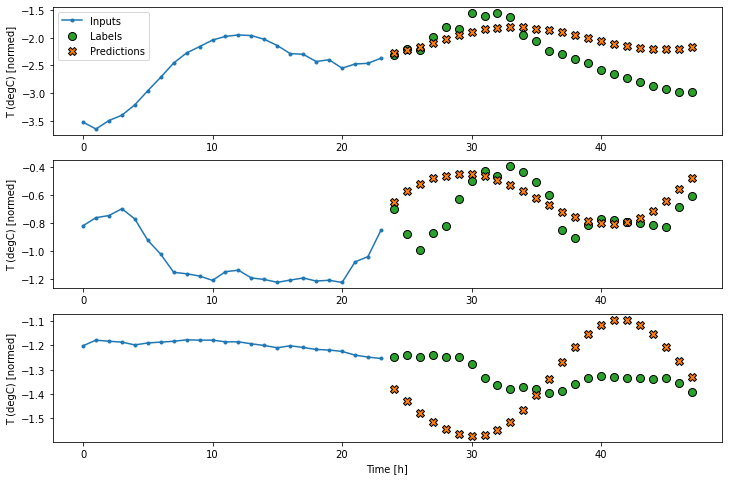

In [139]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

In [140]:
XX = [0 ,1 ,2,3,4,5,6,7]
XX[-1:]
(lambda xy : XX[-1] ) (XX)

7

#### 밀집

입력과 출력 사이에 `layers.Dense`를 추가하면 선현 모델이 더 강력해지지만 여전히 단일 입력에 기반합니다.

30/30 [==============================] - 0s 931us/step - loss: 0.9485 - mean_absolute_error: 0.8210


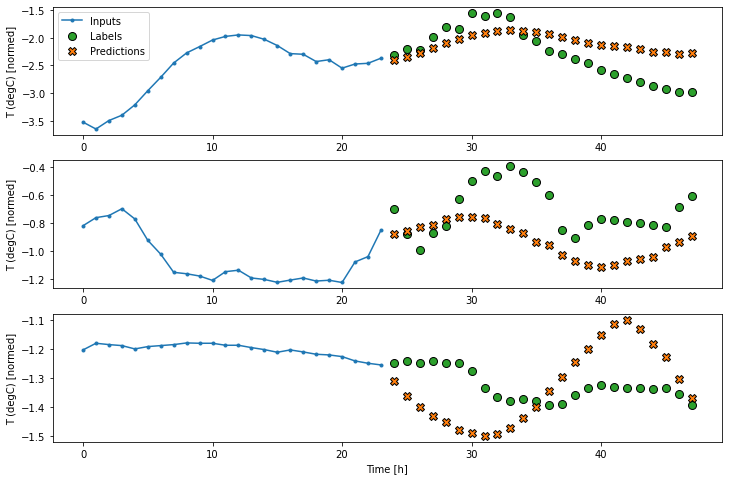

In [141]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

컨볼루션 모델은 고정 너비 기록을 기반으로 예측을 수행하므로 시간에 따라 상황이 어떻게 변하는지 볼 수 있어 밀집 모델보다 성능을 높일 수 있습니다.

![A convolutional model sees how things change over time](https://www.tensorflow.org/tutorials/structured_data/images/multistep_conv.png)

30/30 [==============================] - 0s 898us/step - loss: 1.0047 - mean_absolute_error: 0.8496


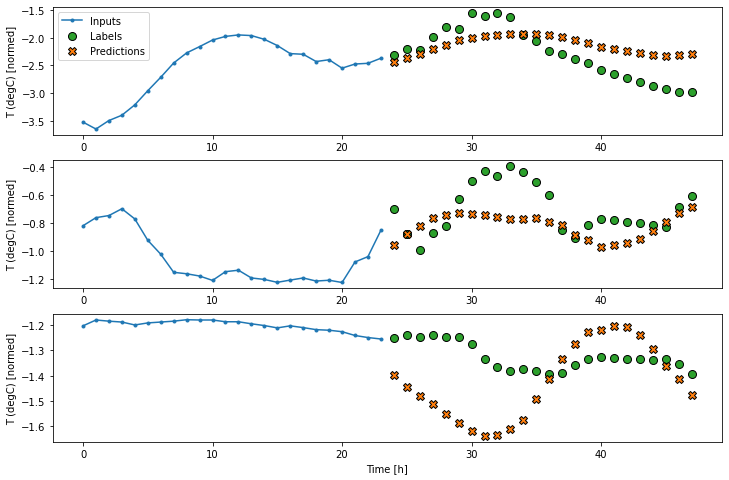

In [142]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

반복 모델은 모델이 수행하는 예측과 관련이 있는 경우 긴 입력 기록을 사용하는 방법을 학습할 수 있습니다. 여기서 모델은 다음 24시간에 대한 단일 예측을 수행하기 전에 24시간 동안 내부 상태를 축적합니다.

이 싱글샷 형식에서 LSTM은 마지막 타임스텝에서만 출력을 생성하면 되므로 `return_sequences=False`를 설정합니다.

![The lstm accumulates state over the input window, and makes a single prediction for the next 24h](https://www.tensorflow.org/tutorials/structured_data/images/multistep_lstm.png)


30/30 [==============================] - 0s 1ms/step - loss: 0.7629 - mean_absolute_error: 0.7076


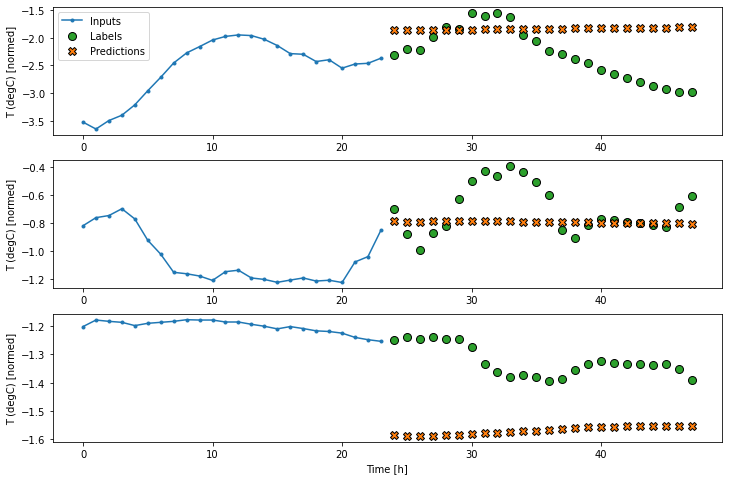

In [143]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### 고급: 자기 회귀 모델

위의 모델은 모두 한 번에 전체 출력 시퀀스를 예측합니다.

경우에 따라 모델이 이 예측을 여러 타임스텝으로 분해하는 것이 도움이 될 수 있습니다. 그러면 이전의 [RNN(Recurrent Neural Networks)을 이용한 시퀀스 생성](https://arxiv.org/abs/1308.0850)에서와 같이 각 모델의 출력을 각 스텝에서 자체 피드백할 수 있어 이전 예측을 조건부로 예측을 수행할 수 있습니다.

이 형태의 모델이 갖는 한 가지 분명한 장점은 다양한 길이의 출력을 생성하도록 설정할 수 있다는 것입니다.

이 튜토리얼의 전반부에서 훈련한 단일 스텝 다중 출력 모델 중 하나를 가져와 자기 회귀 피드백 루프에서 실행할 수 있지만 여기서는 이를 수행하도록 명시적으로 훈련된 모델을 빌드하는 데 중점을 둘 것입니다.

![Feedback a model's output to its input](https://www.tensorflow.org/tutorials/structured_data/images/multistep_autoregressive.png)


#### RNN

이 튜토리얼에서는 자기 회귀 RNN 모델만 빌드하지만 이 패턴은 단일 타임스텝을 출력하도록 설계된 모든 모델에 적용할 수 있습니다.

이 모델은 단일 스텝 `LSTM` 모델과 기본 형태가 동일하여 `LSTM` 다음에 `LSTM` 출력을 모델 예측으로 변환하는 `layers.Dense`가 이어집니다.

`layers.LSTM`은 상태와 시퀀스 결과를 자동으로 관리하는 더 높은 수준의 `layers.RNN`에서 래핑된 `layers.LSTMCell`입니다(자세한 내용은 [Keras RNN](https://www.tensorflow.org/guide/keras/rnn) 참조).

이 경우 모델은 각 스텝에 대한 입력을 수동으로 관리해야 하므로 더 낮은 수준의 단일 타임스텝 인터페이스에 대해 `layers.LSTMCell`를 직접 사용합니다.

In [84]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [85]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

이 모델에 필요한 첫 번째 메서드는 입력을 기반으로 내부 상태를 초기화하는 `warmup` 메서드입니다. 일단 훈련되면 이 상태는 입력 기록의 관련 부분을 캡처합니다. 이는 앞서 알아본 단일 스텝 `LSTM` 모델과 동일합니다.

In [86]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

이 메서드는 단일 타임스텝 예측과 LSTM의 내부 상태를 반환합니다.

In [87]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 19])

`RNN`의 상태 및 초기 예측을 사용하여 이제 이전의 각 스텝에서 수행한 예측을 입력으로 제공하여 모델을 계속 반복할 수 있습니다.

출력 예측을 수집하는 가장 간단한 방법은 Python 목록을 사용하고 루프 후에 `tf.stack`을 사용하는 것입니다.

참고: 이와 같이 Python 목록을 쌓는 것은 훈련을 위해 `Model.compile(..., run_eagerly=True)`를 사용하거나 고정 길이의 출력을 통해 즉시 실행하는 경우에만 효과가 있습니다. 동적 출력 길이의 경우 Python 목록 대신 `tf.TensorArray`를 사용하고 Python `range` 대신 `tf.range`를 사용해야 합니다.

In [88]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

예제 입력에서 이 모델을 테스트 실행합니다.

In [89]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 19)


이제 모델을 훈련합니다.

  1/437 [..............................] - ETA: 0s - loss: 0.2108 - mean_absolute_error: 0.3050

  8/437 [..............................] - ETA: 2s - loss: 0.2444 - mean_absolute_error: 0.3152

 15/437 [>.............................] - ETA: 2s - loss: 0.2362 - mean_absolute_error: 0.3110

 23/437 [>.............................] - ETA: 2s - loss: 0.2322 - mean_absolute_error: 0.3093

 29/437 [>.............................] - ETA: 2s - loss: 0.2317 - mean_absolute_error: 0.3077

 36/437 [=>............................] - ETA: 2s - loss: 0.2316 - mean_absolute_error: 0.3069

 43/437 [=>............................] - ETA: 2s - loss: 0.2306 - mean_absolute_error: 0.3071

 51/437 [==>...........................] - ETA: 2s - loss: 0.2297 - mean_absolute_error: 0.3066

 58/437 [==>...........................] - ETA: 2s - loss: 0.2295 - mean_absolute_error: 0.3065

 66/437 [===>..........................] - ETA: 2s - loss: 0.2297 - mean_absolute_error: 0.3065

 74/437 [====>.........................] - ETA: 2s - loss: 0.2286 - mean_absolute_error: 0.3059

 81/437 [====>.........................] - ETA: 2s - loss: 0.2278 - mean_absolute_error: 0.3055

 88/437 [=====>........................] - ETA: 2s - loss: 0.2273 - mean_absolute_error: 0.3052

 95/437 [=====>........................] - ETA: 2s - loss: 0.2280 - mean_absolute_error: 0.3056

103/437 [======>.......................] - ETA: 2s - loss: 0.2280 - mean_absolute_error: 0.3057

110/437 [======>.......................] - ETA: 2s - loss: 0.2285 - mean_absolute_error: 0.3058

118/437 [=======>......................] - ETA: 2s - loss: 0.2291 - mean_absolute_error: 0.3063

126/437 [=======>......................] - ETA: 2s - loss: 0.2286 - mean_absolute_error: 0.3060

134/437 [========>.....................] - ETA: 2s - loss: 0.2281 - mean_absolute_error: 0.3058

141/437 [========>.....................] - ETA: 2s - loss: 0.2287 - mean_absolute_error: 0.3060

149/437 [=========>....................] - ETA: 2s - loss: 0.2285 - mean_absolute_error: 0.3058

156/437 [=========>....................] - ETA: 2s - loss: 0.2285 - mean_absolute_error: 0.3059

163/437 [==========>...................] - ETA: 1s - loss: 0.2290 - mean_absolute_error: 0.3061

171/437 [==========>...................] - ETA: 1s - loss: 0.2290 - mean_absolute_error: 0.3059

178/437 [===========>..................] - ETA: 1s - loss: 0.2299 - mean_absolute_error: 0.3062

185/437 [===========>..................] - ETA: 1s - loss: 0.2298 - mean_absolute_error: 0.3060

192/437 [============>.................] - ETA: 1s - loss: 0.2303 - mean_absolute_error: 0.3061

199/437 [============>.................] - ETA: 1s - loss: 0.2304 - mean_absolute_error: 0.3061

206/437 [=============>................] - ETA: 1s - loss: 0.2301 - mean_absolute_error: 0.3059

213/437 [=============>................] - ETA: 1s - loss: 0.2300 - mean_absolute_error: 0.3059

220/437 [==============>...............] - ETA: 1s - loss: 0.2299 - mean_absolute_error: 0.3058

227/437 [==============>...............] - ETA: 1s - loss: 0.2294 - mean_absolute_error: 0.3056

234/437 [===============>..............] - ETA: 1s - loss: 0.2292 - mean_absolute_error: 0.3055

242/437 [===============>..............] - ETA: 1s - loss: 0.2290 - mean_absolute_error: 0.3056

249/437 [================>.............] - ETA: 1s - loss: 0.2290 - mean_absolute_error: 0.3057

256/437 [================>.............] - ETA: 1s - loss: 0.2290 - mean_absolute_error: 0.3057

263/437 [=================>............] - ETA: 1s - loss: 0.2291 - mean_absolute_error: 0.3057

270/437 [=================>............] - ETA: 1s - loss: 0.2293 - mean_absolute_error: 0.3058

277/437 [==================>...........] - ETA: 1s - loss: 0.2288 - mean_absolute_error: 0.3055

284/437 [==================>...........] - ETA: 1s - loss: 0.2285 - mean_absolute_error: 0.3053

291/437 [==================>...........] - ETA: 1s - loss: 0.2284 - mean_absolute_error: 0.3053

298/437 [===================>..........] - ETA: 1s - loss: 0.2280 - mean_absolute_error: 0.3051

305/437 [===================>..........] - ETA: 0s - loss: 0.2283 - mean_absolute_error: 0.3053

312/437 [====================>.........] - ETA: 0s - loss: 0.2288 - mean_absolute_error: 0.3055

319/437 [====================>.........] - ETA: 0s - loss: 0.2292 - mean_absolute_error: 0.3058

326/437 [=====================>........] - ETA: 0s - loss: 0.2292 - mean_absolute_error: 0.3058

334/437 [=====================>........] - ETA: 0s - loss: 0.2293 - mean_absolute_error: 0.3059

341/437 [======================>.......] - ETA: 0s - loss: 0.2294 - mean_absolute_error: 0.3060

349/437 [======================>.......] - ETA: 0s - loss: 0.2291 - mean_absolute_error: 0.3059

356/437 [=======================>......] - ETA: 0s - loss: 0.2293 - mean_absolute_error: 0.3059

364/437 [=======================>......] - ETA: 0s - loss: 0.2292 - mean_absolute_error: 0.3059

372/437 [========================>.....] - ETA: 0s - loss: 0.2292 - mean_absolute_error: 0.3058

379/437 [=========================>....] - ETA: 0s - loss: 0.2295 - mean_absolute_error: 0.3060

387/437 [=========================>....] - ETA: 0s - loss: 0.2297 - mean_absolute_error: 0.3061

394/437 [==========================>...] - ETA: 0s - loss: 0.2297 - mean_absolute_error: 0.3061

401/437 [==========================>...] - ETA: 0s - loss: 0.2300 - mean_absolute_error: 0.3063

408/437 [===========================>..] - ETA: 0s - loss: 0.2299 - mean_absolute_error: 0.3062

416/437 [===========================>..] - ETA: 0s - loss: 0.2299 - mean_absolute_error: 0.3062

424/437 [============================>.] - ETA: 0s - loss: 0.2301 - mean_absolute_error: 0.3062

430/437 [============================>.] - ETA: 0s - loss: 0.2304 - mean_absolute_error: 0.3063

437/437 [==============================] - 3s 7ms/step - loss: 0.2302 - mean_absolute_error: 0.3062


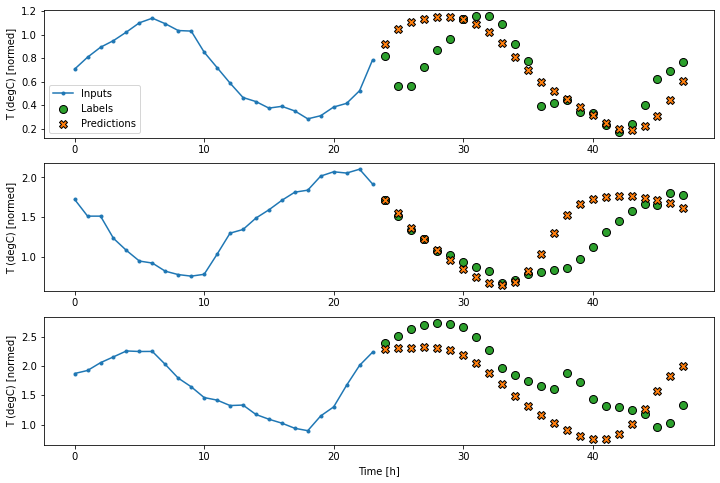

In [90]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### 성능

이 문제에 대해 모델 복잡성이 증가함에 따라 분명히 이득이 감소합니다.

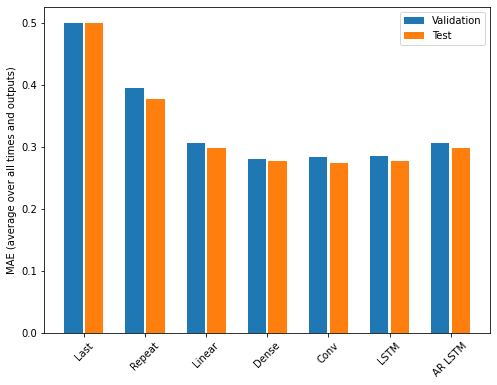

In [91]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

이 튜토리얼의 전반부에서 소개한 다중 출력 모델에 대한 메트릭은 모든 출력 특성에 평균화된 성능을 보여줍니다. 이러한 성능은 유사하지만 출력 타임스텝에서도 평균화됩니다. 

In [92]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.5007
Repeat  : 0.3774
Linear  : 0.2986
Dense   : 0.2771
Conv    : 0.2749
LSTM    : 0.2773
AR LSTM : 0.2990


밀집 모델에서 컨볼루션 및 반복 모델로 이동하여 얻은 이득은 몇 퍼센트(있다고 하더라도)에 불과하며 자기 회귀 모델의 성능은 분명히 더 나빴습니다. 따라서 이러한 더 복잡한 접근 방법은 **이** 문제에서는 가치가 없을 수도 있지만 시도해 보기 전에는 알 수 있는 방법이 없었으며 이러한 모델은 **다른 특정** 문제에 도움이 될 수 있습니다.

## 다음 단계

이 튜토리얼에서는 TensorFlow를 사용한 시계열 예측에 대해 간단히 소개했습니다.

- 자세한 내용은 다음을 참조하세요.
    - [Scikit-Learn, Keras 및 TensorFlow를 이용한 머시러닝 실무](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)(2차 개정 버전), 챕터 15
    - [Python을 이용한 딥러닝](https://www.manning.com/books/deep-learning-with-python) 챕터 6
    - [Udacity의 딥러닝 TensorFlow 개론](https://www.udacity.com/course/intro-to-tensorflow-for-deep-learning--ud187) 레슨 8 및 [연습 노트북](https://github.com/tensorflow/examples/tree/master/courses/udacity_intro_to_tensorflow_for_deep_learning)
- 또한 TensorFlow에서 [기존의 시계열 모델](https://otexts.com/fpp2/index.html)은 모두 구현할 수 있다는 점을 기억하세요. 이 튜토리얼에서는 TensdorFlow의 내장 기능에 초점을 맞추었습니다.